# Install Libraries

In [ ]:
pip install pm4py

In [ ]:
pip install --upgrade pm4py

In [ ]:
import pm4py.statistics

print(dir(pm4py.statistics))

# Load Libraries

In [ ]:
# Allow Colab to see Google Drive files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# PM4PY imports
import pm4py
import pm4py.statistics
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.obj import EventLog, Trace
from pm4py.statistics.end_activities.log import get as end_activities_get
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.statistics.variants.log import get as variants_module
from pm4py.objects.conversion.log import converter as log_converter

# Load Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Project/process_mining/dataset/Incident_Management_CSV.csv', sep=';')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M')
df.head(5)

,Case ID,Variant,Priority,Reporter,Timestamp,Event,Issue Type,Resolver,Report Channel,Short Description,Customer Satisfaction
0,INC0001,Variant 4,Medium,Alice,2023-11-17 11:17:00,Ticket created,Performance Issue,NaN,Website,Application crash,3
1,INC0001,Variant 4,Medium,Alice,2023-11-17 13:30:00,Ticket assigned to level 1 support,Performance Issue,Sam,Website,Application crash,3
2,INC0001,Variant 4,Medium,Alice,2023-11-17 14:06:00,WIP - level 1 support,Performance Issue,Sam,Website,Application crash,3
3,INC0001,Variant 4,Medium,Alice,2023-11-17 16:52:00,Level 1 escalates to level 2 support,Performance Issue,Michael,Website,Application crash,3
4,INC0001,Variant 4,Medium,Alice,2023-11-17 18:07:00,WIP - level 2 support,Performance Issue,Emma,Website,Application crash,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242901 entries, 0 to 242900
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Case ID                242901 non-null  object        
 1   Variant                242901 non-null  object        
 2   Priority               242901 non-null  object        
 3   Reporter               242901 non-null  object        
 4   Timestamp              242901 non-null  datetime64[ns]
 5   Event                  242901 non-null  object        
 6   Issue Type             242901 non-null  object        
 7   Resolver               146405 non-null  object        
 8   Report Channel         242901 non-null  object        
 9   Short Description      242901 non-null  object        
 10  Customer Satisfaction  242901 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 20.4+ MB


In [ ]:
# number of cases
len(df['Case ID'].unique())

31588

In [ ]:
# number of events
len(df)

242901

## Missing value check

In [ ]:
# missing values
df.isnull().sum()

,0
Case ID,0
Variant,0
Priority,0
Reporter,0
Timestamp,0
Event,0
Issue Type,0
Resolver,96496
Report Channel,0
Short Description,0


In [ ]:
df['Resolver'].value_counts()

,count
Resolver,
Sam,49347
Emma,31873
David,26536
Michael,21973
Sarah,9478
James,2678
William,2246
Olivia,1819
Ava,455


In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

,0
Case ID,0
Variant,0
Priority,0
Reporter,0
Timestamp,0
Event,0
Issue Type,0
Resolver,0
Report Channel,0
Short Description,0


## Variable checking

In [ ]:
df['Variant'].value_counts()

,count
Variant,
Variant 3,59505
Variant 1,29688
Variant 7,15132
Variant 4,11170
Variant 5,8316
Variant 6,5026
Variant 8,4770
Variant 9,4375
Variant 11,1878


In [ ]:
df['Resolver'].value_counts()

,count
Resolver,
Sam,49347
Emma,31873
David,26536
Michael,21973
Sarah,9478
James,2678
William,2246
Olivia,1819
Ava,455


In [ ]:
df['Priority'].value_counts()

,count
Priority,
Medium,72695
Low,43758
High,29952


In [ ]:
df['Issue Type'].value_counts()

,count
Issue Type,
Performance Issue,37603
Bug,36795
Feature Request,26467
Incident,19326
Service Request,12880
Maintenance,6732
Technical Issue,6602


In [ ]:
df['Customer Satisfaction'].value_counts()

,count
Customer Satisfaction,
4,46588
3,46226
1,18550
2,17610
5,17431


In [ ]:
df['Event'].value_counts()

,count
Event,
WIP - level 1 support,32223
Ticket assigned to level 1 support,31250
WIP - level 2 support,21955
Ticket solved by level 2 support,19043
Level 1 escalates to level 2 support,18216
Ticket solved by level 1 support,11475
Ticket assigned to level 2 support,3485
WIP - level 3 support,3240
Level 2 escalates to level 3 support,3240


# Formatting Data Frames

In [ ]:
# Ensure correct PM4Py format (renaming for consistency)
log_df = df.rename(columns={
    'Case ID': 'case:concept:name',
    'Variant': 'trace:variant',
    'Event': 'concept:name',
    'Timestamp': 'time:timestamp',
    'Priority': 'trace:priority',
    'Issue Type': 'trace:issue_type',
    'Report Channel': 'trace:report_channel',
    'Customer Satisfaction': 'trace:customer_satisfaction',
    'Reporter': 'event:reporter',
    'Resolver': 'event:resolver',
    'Short Description': 'event:short_description'
})

log_df.head(5)

,case:concept:name,trace:variant,trace:priority,event:reporter,time:timestamp,concept:name,trace:issue_type,event:resolver,trace:report_channel,event:short_description,trace:customer_satisfaction
1,INC0001,Variant 4,Medium,Alice,2023-11-17 13:30:00,Ticket assigned to level 1 support,Performance Issue,Sam,Website,Application crash,3
2,INC0001,Variant 4,Medium,Alice,2023-11-17 14:06:00,WIP - level 1 support,Performance Issue,Sam,Website,Application crash,3
3,INC0001,Variant 4,Medium,Alice,2023-11-17 16:52:00,Level 1 escalates to level 2 support,Performance Issue,Michael,Website,Application crash,3
4,INC0001,Variant 4,Medium,Alice,2023-11-17 18:07:00,WIP - level 2 support,Performance Issue,Emma,Website,Application crash,3
5,INC0001,Variant 4,Medium,Alice,2023-11-17 20:10:00,Ticket solved by level 2 support,Performance Issue,Sarah,Website,Application crash,3


In [ ]:
log_df = pm4py.format_dataframe(log_df)
log_df.head(5)

,case:concept:name,trace:variant,trace:priority,event:reporter,time:timestamp,concept:name,trace:issue_type,event:resolver,trace:report_channel,event:short_description,trace:customer_satisfaction,@@index,@@case_index
0,INC0001,Variant 4,Medium,Alice,2023-11-17 13:30:00,Ticket assigned to level 1 support,Performance Issue,Sam,Website,Application crash,3,0,0
1,INC0001,Variant 4,Medium,Alice,2023-11-17 14:06:00,WIP - level 1 support,Performance Issue,Sam,Website,Application crash,3,1,0
2,INC0001,Variant 4,Medium,Alice,2023-11-17 16:52:00,Level 1 escalates to level 2 support,Performance Issue,Michael,Website,Application crash,3,2,0
3,INC0001,Variant 4,Medium,Alice,2023-11-17 18:07:00,WIP - level 2 support,Performance Issue,Emma,Website,Application crash,3,3,0
4,INC0001,Variant 4,Medium,Alice,2023-11-17 20:10:00,Ticket solved by level 2 support,Performance Issue,Sarah,Website,Application crash,3,4,0


In [ ]:
# sort the log by the case ID and timestamp
log_df = log_df.sort_values(by=['time:timestamp'])
log_df.head(5)

,case:concept:name,trace:variant,trace:priority,event:reporter,time:timestamp,concept:name,trace:issue_type,event:resolver,trace:report_channel,event:short_description,trace:customer_satisfaction,@@index,@@case_index
80129,INC2480,Variant 8,High,John,2023-01-01 01:42:00,Ticket assigned to level 1 support,Bug,Sam,Website,Printer not working,4,80129,17279
80130,INC2480,Variant 8,High,John,2023-01-01 01:55:00,WIP - level 1 support,Bug,Sam,Website,Printer not working,4,80130,17279
15759,INC12184,Variant 5,High,Emily,2023-01-01 02:21:00,Ticket assigned to level 1 support,Feature Request,Sam,Email,New feature request,4,15759,3402
78937,INC24554,Variant 3,High,Charlie,2023-01-01 02:23:00,Ticket assigned to level 1 support,Performance Issue,Sam,Email,Data loss issue,5,78937,17009
15760,INC12184,Variant 5,High,Emily,2023-01-01 02:47:00,WIP - level 1 support,Feature Request,Sam,Email,New feature request,4,15760,3402


In [ ]:
print("Number of cases:", log_df['case:concept:name'].nunique())
print("Number of Event", log_df['concept:name'].nunique())
print("Time range:", log_df['time:timestamp'].min(), log_df['time:timestamp'].max())

Number of cases: 31588
Number of Event 13
Time range: 2023-01-01 01:42:00 2024-01-02 03:22:00


In [ ]:
print(log_df.duplicated().sum())

0


In [ ]:
log_df.to_csv('/content/drive/MyDrive/ML Project/process_mining/dataset/log_df_data.csv', index=False)

# Process Discovery

## BPMN (Business Process Modeling Notation)

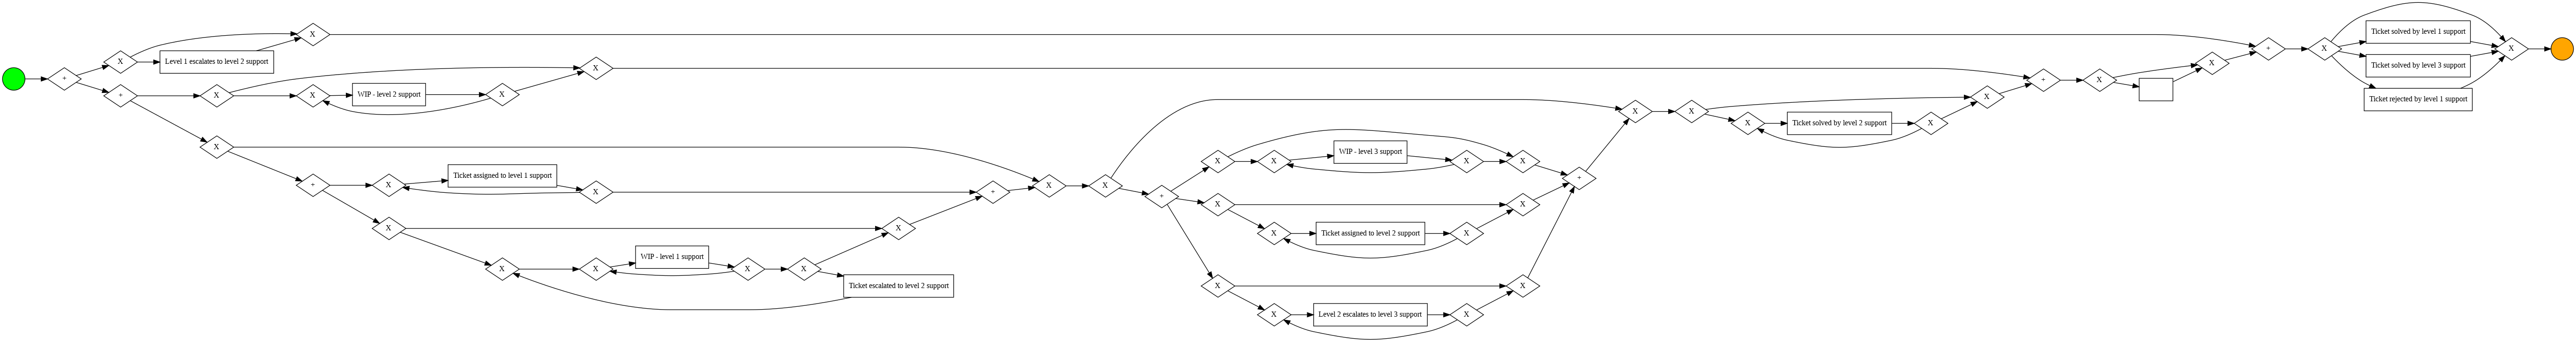

In [ ]:
bpmn_model = pm4py.discover_bpmn_inductive(log_df)
pm4py.view_bpmn(bpmn_model)

* Events (Circles) : Start and End events
* Activities (Rectangles) : Activities or Work, Task
* Gateways (Diamonds) : Gateways control the divergence (splitting) and convergence (merging) of the Sequence flow.  
  * Exclusive (XOR, X or empty) : only one path can be taken. A choice is made.
  * Parallel ( + ) : All outgoing paths are executed concurrently (in parallel). Multiple things happen at the same time.
* Bottlenecks : Gateways that merge flows (multiple inputs) or waiting points.
* High Path (Happy Path) : A line going directly across the top, it bypasses many steps.
* Low path : The lower path shows a series of diamonds and branching logics, more complex cases.



## Process Tree

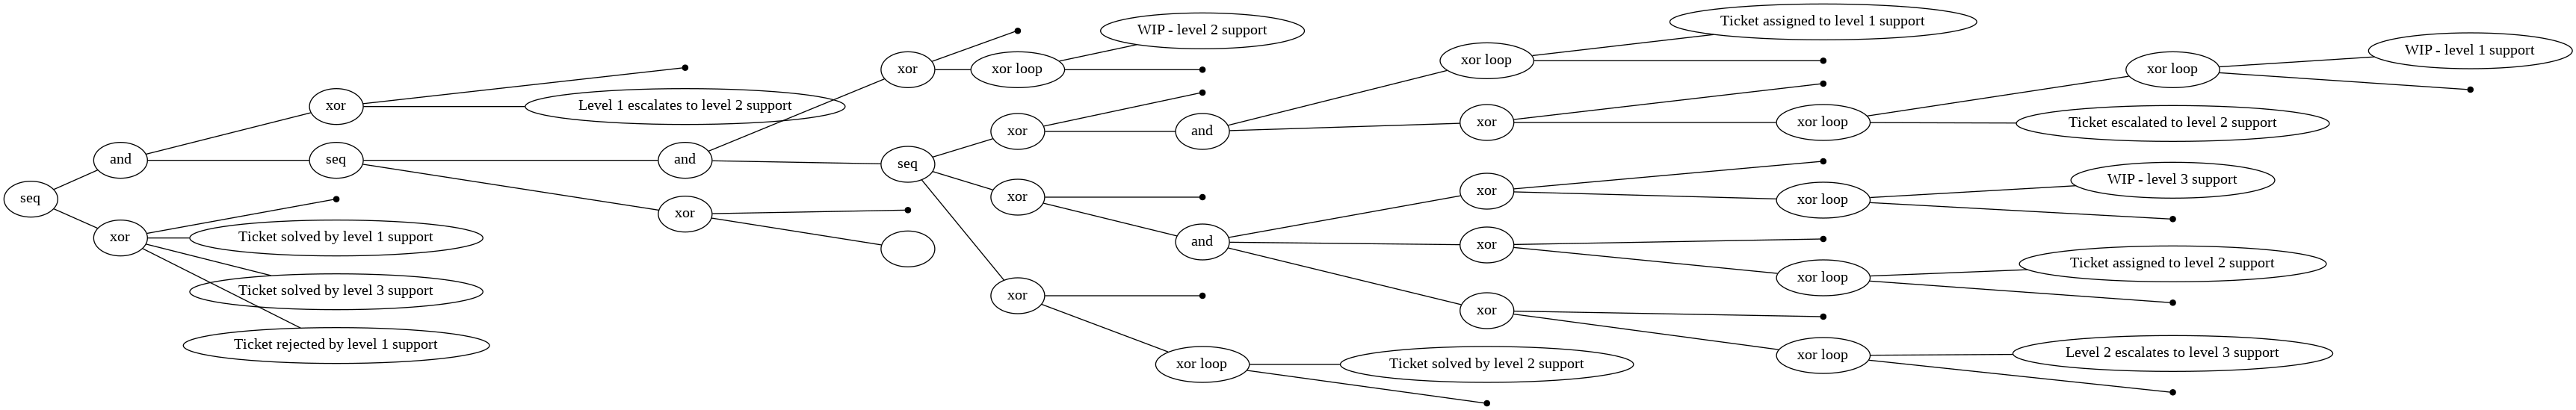

In [ ]:
process_tree = pm4py.discover_process_tree_inductive(log_df)
pm4py.view_process_tree(process_tree)

* seq (sequence) : activities must be executed one after the other in the order they appear
* xor (Exclusive Choice) : Only one of the paths/activites nested below the xor can be executed. xor is a decision point.
* and (parallel) : All paths/activities nested below the 'and' must be executed. They can be done concurrently.
* xor loop : XOR combines XOR and SEQ. it represents rework or iteration in a situation where an activity or sequence of activities must be repeated zero or more times until a certain condition is met to allow the case to proceed.

< Initial interpretation >

1. The first action is an [and]. It means the case simultaneously splits into two or more independent tracks. The process starts wor on two major tracks at once (xor and seq)

2. the lower [xor] is a major decision point and controls the final outcome of Level 1 attempt, resulting in Ticket solved by level support, Ticket solved by level 3 support, and Ticket rejected by level 1 support.

This part of the model suggests that after a certain point (determined by the initial seq), the case is either handled and solved (by L1 or L3) or rejected. ALso, [xor loop] suggests that many tickets require multiple attempts after the initial escalation, being a common bottleneck area.

The final process consists of multiple [xor loop] processes, indicating that the process is highly iterative and complex, including rework, validation, quality check, or iterative problem-solving.

We assume that Level 1 support is the simplest support and Level 3 is the most complicated support.

* [WIP - level 1 support] with XOR loop : basic issue check
* [Toclet escalated to level 2 support], [Ticket assigned to level 2 support]
: iterative debugging, escalating a ticket multiple times within Level 2 until a solution is done.  
* [WIP - level 3 support], [Level 2 escalates to level 3 support] : they represent the most complex, multiple iterations, indicating inefficiency and bottlenecks.

## Petri net

### Create the Petri Net structure from the event log
* struggles with complex stuructures.
* lack of proper termination (if the log is imcomplete or noisy)
* early techniques

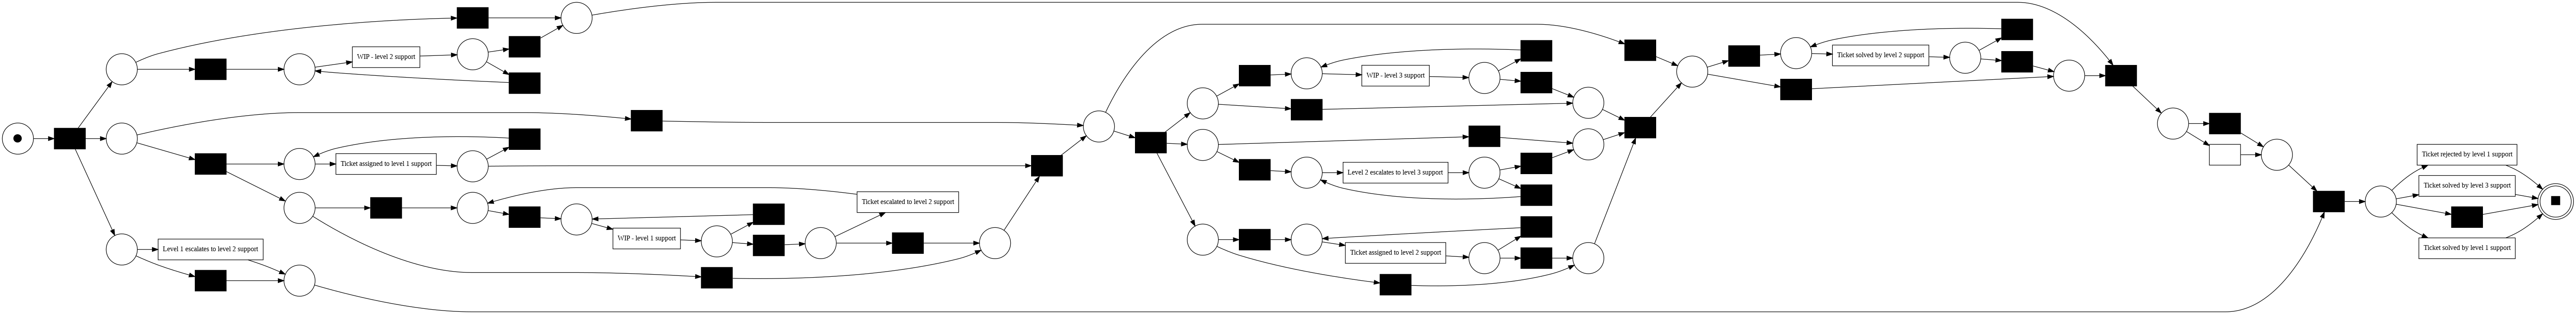

In [ ]:
# Let the algorithm directly return a Petri net
net1, im1, fm1 = pm4py.discover_petri_net_inductive(log_df)
pm4py.view_petri_net(net1, im1, fm1)

### Create Petri Net from Process Tree
* Structured discovery based on operators (SEQ, XOR, AND)  
* Free of deadlocks, better structure  
* cleaner, easier model
* good for both describing the current process and predicting valid future behavior.  

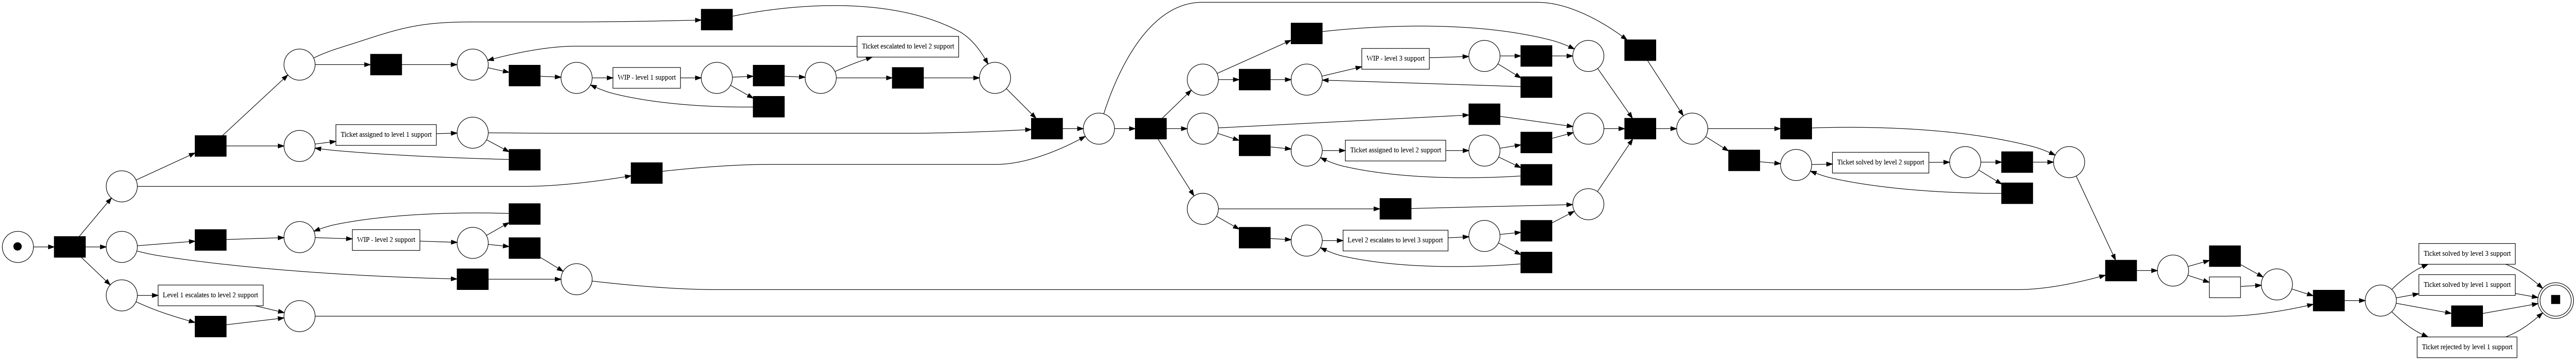

In [ ]:
# convert the obtained process (intenally conversion) tree to a Petri net
net2, im2, fm2 = pm4py.convert_to_petri_net(process_tree)
pm4py.view_petri_net(net2, im2, fm2)

* Circles : States, Conditions (where the case waits)  
* Black Squares (Transition) : Activities, Events (where work is done)  
* Black Dot (Token) : A case waiting for the next step.

1. The process begins with a single token. The initial split shows three independent and concurrent paths.

2. As shown in Process tree, Petri net also display complicated steps, including [WIP - level 3 support], [Ticket assigned to level 2 support], and [Level 2 escalates to level 3 support], with interations and loops.

* Highly Parallel : Three tracks start concurrently.
* Iterative : Rework loops are built into every level (L1, L2, L3 WIP) to handle quality control.  

* There is a single Transition (black square ) with multiple incoming paths. The transition is a mandatory waiting point (probably bottleneck). The case must wait for a token to arrive in all of its input Places before the process can move forward.

* Top : WIP - level 3 support (Must complete before the join)  
* Middle : Ticket assigned to level 2 support (Must complete before the join)  
* Botton : Level 2 escalates to level 3 support (Must complete before the join)



# Feature Engineering

## Case-Level Trace Attributes

In [ ]:
# Extracting unique trace attributes (Variant, Priority, Issue Type, Report Channel, Customer Satisfaction)
# We need to make sure we get one value per case.

case_attributes = log_df.groupby('case:concept:name').agg(
    reported_by = ('event:reporter', 'first'),
    priority=('trace:priority', 'first'),
    issue_type=('trace:issue_type', 'first'),
    report_channel=('trace:report_channel', 'first'),
    customer_satisfaction=('trace:customer_satisfaction', 'first')
)

case_attributes.head(5)


,reported_by,priority,issue_type,report_channel,customer_satisfaction
case:concept:name,,,,,
INC0001,Alice,Medium,Performance Issue,Website,3
INC0002,Charlie,High,Performance Issue,App,3
INC0003,Alice,High,Feature Request,Website,4
INC0004,Bob,Medium,Incident,Email,4
INC0005,John,Low,Performance Issue,Website,3


In [ ]:
features_df = case_attributes.copy()

In [ ]:
print("\n--- Case-Level Trace Attributes (Updated) ---")
features_df[['priority', 'issue_type', 'report_channel', 'reported_by', 'customer_satisfaction']].head(5)


--- Case-Level Trace Attributes (Updated) ---


,priority,issue_type,report_channel,reported_by,customer_satisfaction
case:concept:name,,,,,
INC0001,Medium,Performance Issue,Website,Alice,3
INC0002,High,Performance Issue,App,Charlie,3
INC0003,High,Feature Request,Website,Alice,4
INC0004,Medium,Incident,Email,Bob,4
INC0005,Low,Performance Issue,Website,John,3


## Variant Analysis

In [ ]:
from pm4py.statistics.traces.generic.log import case_statistics

variants = case_statistics.get_variant_statistics(log_df)
variants = sorted(variants, key=lambda x: x['count'], reverse=True)
print("13 process variants:")
for v in variants[:13]:
    print(v)

13 process variants:
{'variant': ('Ticket assigned to level 1 support', 'WIP - level 1 support', 'Level 1 escalates to level 2 support', 'WIP - level 2 support', 'Ticket solved by level 2 support'), 'count': 14135}
{'variant': ('Ticket assigned to level 1 support', 'WIP - level 1 support', 'Ticket solved by level 1 support'), 'count': 9896}
{'variant': ('Ticket assigned to level 1 support', 'WIP - level 1 support', 'Level 1 escalates to level 2 support', 'WIP - level 2 support', 'Level 2 escalates to level 3 support', 'WIP - level 3 support', 'Ticket assigned to level 2 support', 'WIP - level 2 support', 'Level 2 escalates to level 3 support', 'WIP - level 3 support', 'Ticket assigned to level 2 support', 'Ticket solved by level 2 support'), 'count': 1261}
{'variant': ('Ticket assigned to level 1 support', 'WIP - level 1 support', 'Level 1 escalates to level 2 support', 'WIP - level 2 support', 'Ticket solved by level 2 support', 'WIP - level 2 support', 'Ticket solved by level 2 suppo

In [ ]:
variants_count = variants_module.get_variants(log_df)
variant_stats = []

for variant_name, traces in variants_count.items():
    case_ids = [trace.attributes['concept:name'] for trace in traces]

    # Filter out cases with only one event before calculating duration
    variant_cases = log_df[log_df['case:concept:name'].isin(case_ids)].groupby('case:concept:name').filter(lambda x: len(x) > 1)

    avg_satisfaction = log_df[log_df['case:concept:name'].isin(case_ids)]['trace:customer_satisfaction'].mean()

    avg_duration = variant_cases.groupby('case:concept:name')['time:timestamp'].apply(
        lambda x: (x.max() - x.min()).total_seconds() / 3600
        ).mean()

    variant_stats.append({
        'Variant': variant_name,
        'Frequency (#Cases)': len(traces),
        'Avg Satisfaction': round(avg_satisfaction, 2) if not pd.isna(avg_satisfaction) else None,
        'Avg Duration (hrs)': round(avg_duration, 2) if not pd.isna(avg_duration) else None
    })

variants_df = pd.DataFrame(variant_stats).sort_values(by='Frequency (#Cases)', ascending=False)

In [ ]:
variants_df

,Variant,Frequency (#Cases),Avg Satisfaction,Avg Duration (hrs)
2,"(Ticket assigned to level 1 support, WIP - lev...",14135,3.26,10.19
3,"(Ticket assigned to level 1 support, WIP - lev...",9896,3.51,5.24
4,"(Ticket assigned to level 1 support, WIP - lev...",1261,1.90,20.60
1,"(Ticket assigned to level 1 support, WIP - lev...",1188,3.53,17.35
6,"(Ticket assigned to level 2 support, WIP - lev...",963,3.51,5.63
0,"(Ticket assigned to level 1 support, WIP - lev...",954,3.55,15.92
7,"(Ticket assigned to level 1 support, Ticket re...",934,2.06,1.01
5,"(Ticket assigned to level 1 support, WIP - lev...",718,3.47,12.52
8,"(Ticket assigned to level 1 support, WIP - lev...",625,3.48,16.11
9,"(Ticket assigned to level 1 support, WIP - lev...",605,1.72,5.26


# Process Performance & Satisfaction Analysis








Case ID: case:concept:name  
Variant': trace:variant  
Event: concept:name  
'Timestamp': 'time:timestamp',  
'Priority': 'trace:priority',  
'Issue Type': 'trace:issue_type',  
'Report Channel': 'trace:report_channel',  
'Customer Satisfaction': 'trace:customer_satisfaction',  
'Reporter': 'event:reporter',  
'Resolver': 'event:resolver',  
'Short Description': 'event:short_description'  

In [ ]:
# Case duration

log_df['case_duration'] = log_df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: (x.max() - x.min()).total_seconds()/60)
log_df.head(5)

,case:concept:name,trace:variant,trace:priority,event:reporter,time:timestamp,concept:name,trace:issue_type,event:resolver,trace:report_channel,event:short_description,trace:customer_satisfaction,@@index,@@case_index,case_duration
80129,INC2480,Variant 8,High,John,2023-01-01 01:42:00,Ticket assigned to level 1 support,Bug,Sam,Website,Printer not working,4,80129,17279,405.0
80130,INC2480,Variant 8,High,John,2023-01-01 01:55:00,WIP - level 1 support,Bug,Sam,Website,Printer not working,4,80130,17279,405.0
15759,INC12184,Variant 5,High,Emily,2023-01-01 02:21:00,Ticket assigned to level 1 support,Feature Request,Sam,Email,New feature request,4,15759,3402,481.0
78937,INC24554,Variant 3,High,Charlie,2023-01-01 02:23:00,Ticket assigned to level 1 support,Performance Issue,Sam,Email,Data loss issue,5,78937,17009,264.0
15760,INC12184,Variant 5,High,Emily,2023-01-01 02:47:00,WIP - level 1 support,Feature Request,Sam,Email,New feature request,4,15760,3402,481.0


In [ ]:
# Correlation Analysis

corr = log_df[['case_duration', 'trace:customer_satisfaction']].corr()
corr

,case_duration,trace:customer_satisfaction
case_duration,1.000000,-0.137539
trace:customer_satisfaction,-0.137539,1.000000


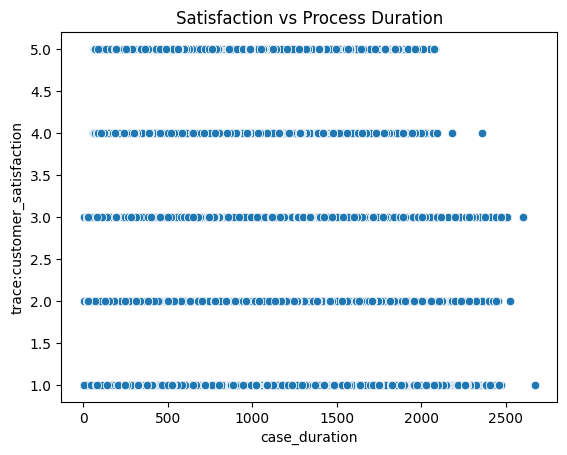

In [ ]:
sns.scatterplot(x='case_duration', y='trace:customer_satisfaction', data=log_df)
plt.title("Satisfaction vs Process Duration")
plt.show()

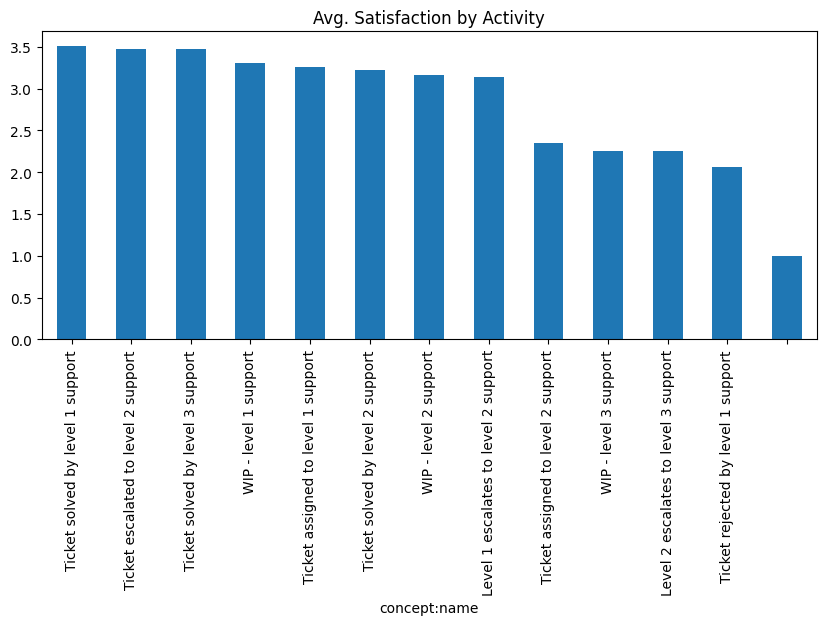

In [ ]:
# event (activity) and customer satisfaction

activity_avg_satisfaction = log_df.groupby('concept:name')['trace:customer_satisfaction'].mean().sort_values(ascending=False)
activity_avg_satisfaction.plot(kind='bar', figsize=(10,4), title="Avg. Satisfaction by Activity")
plt.show()

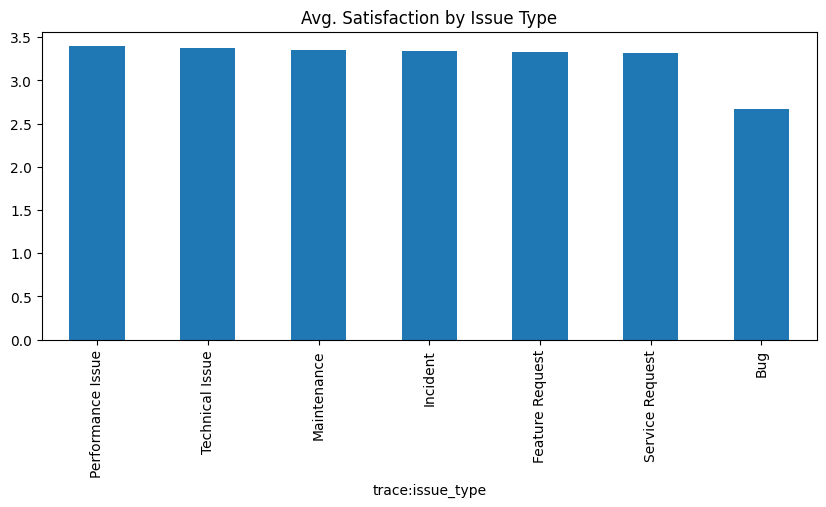

In [ ]:
# Issue Type (trace:issue_type) and customer satisfaction

issue_avg_satisfaction = log_df.groupby('trace:issue_type')['trace:customer_satisfaction'].mean().sort_values(ascending=False)
issue_avg_satisfaction.plot(kind='bar', figsize=(10,4), title="Avg. Satisfaction by Issue Type")
plt.show()

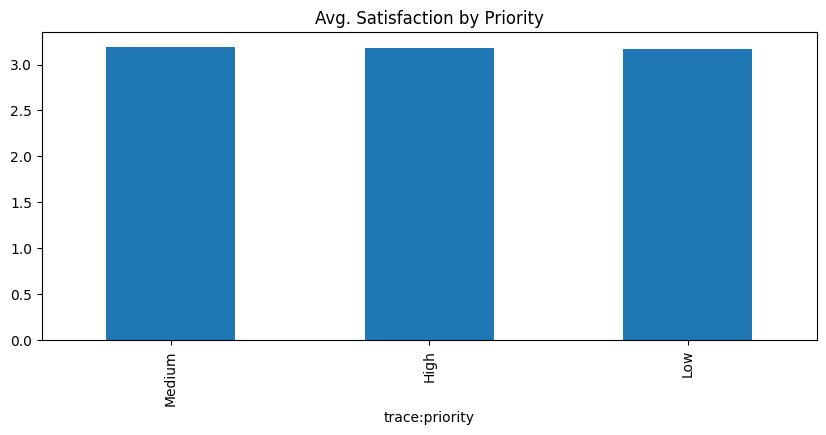

In [ ]:
# Priority (trace:priority) and customer satisfaction

priority_avg_satisfaction = log_df.groupby('trace:priority')['trace:customer_satisfaction'].mean().sort_values(ascending=False)
priority_avg_satisfaction.plot(kind='bar', figsize=(10,4), title="Avg. Satisfaction by Priority")
plt.show()

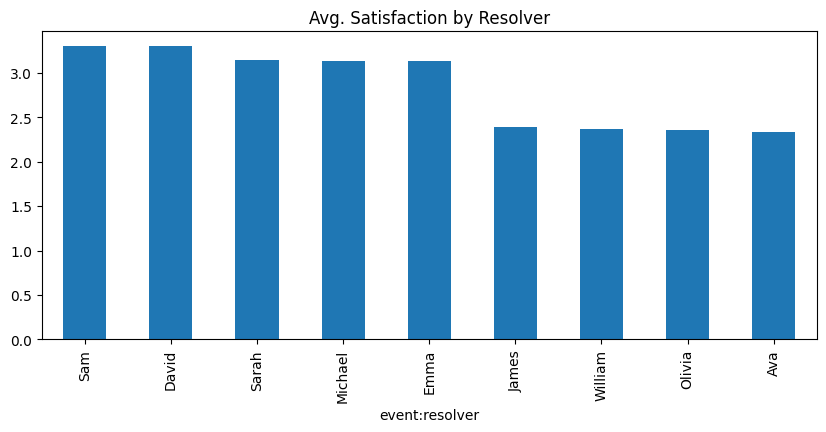

In [ ]:
# Resolver (event:resolver), and customer satisfaction

resolver_avg_satisfaction = log_df.groupby('event:resolver')['trace:customer_satisfaction'].mean().sort_values(ascending=False)
resolver_avg_satisfaction.plot(kind='bar', figsize=(10,4), title="Avg. Satisfaction by Resolver")
plt.show()

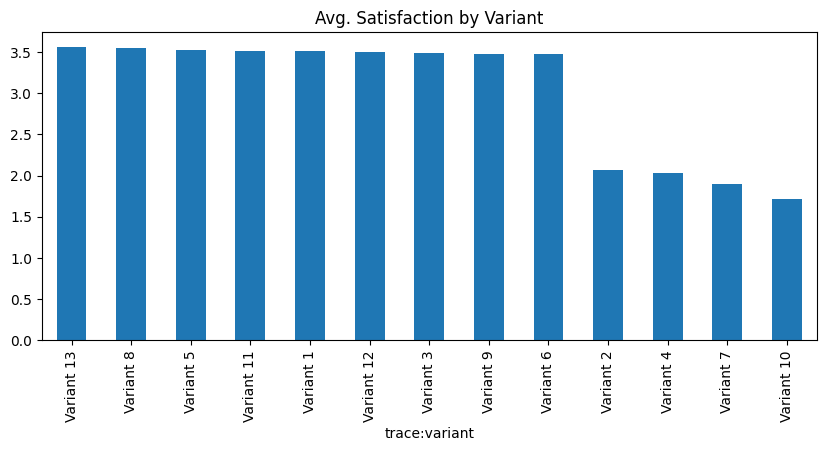

In [ ]:
# Variant(trace:variant), and customer satisfaction

variant_avg_satisfaction = log_df.groupby('trace:variant')['trace:customer_satisfaction'].mean().sort_values(ascending=False)
variant_avg_satisfaction.plot(kind='bar', figsize=(10,4), title="Avg. Satisfaction by Variant")
plt.show()

# LLM Integration

In [ ]:
API = "ADD_YOUR_KEY"

## 1. Activity analysis

In [ ]:
# Process inslgith using LLM - based on activity

from openai import OpenAI

client = OpenAI(api_key = API)

prompt = f"""
You are a process mining analyst. From the following metrics, summarize the main process bottlenecks and their impact on customer satisfaction.

Average satisfaction: {round(log_df['trace:customer_satisfaction'].mean(), 2)}
Average duration: {round(log_df['case_duration'].mean(), 2)} minutes
Lowest-rated activities: {activity_avg_satisfaction.tail(3).to_dict()}
"""

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[{"role": "user", "content": prompt}]
)

print("LLM Insight:\n", response.choices[0].message.content)


LLM Insight:
 Based on the metrics provided, the main process bottlenecks seem to be in the activities of 'Level 2 escalates to level 3 support' and 'Ticket rejected by level 1 support', which are the lowest-rated activities. These activities are likely causing delays and dissatisfaction among customers, as reflected in the relatively low average satisfaction score of 3.18. 

The average duration of 655.4 minutes also indicates that the process may be taking longer than desired, potentially leading to frustration among customers. Improving the efficiency and effectiveness of these bottleneck activities could help enhance customer satisfaction and overall process performance.


## 2. Issue analysis

In [ ]:
# Process inslgith using LLM - based on issue type

from openai import OpenAI

client = OpenAI(api_key = API)

prompt = f"""
You are a process mining analyst. From the following metrics, summarize the main process bottlenecks and their impact on customer satisfaction.

Average satisfaction: {round(log_df['trace:customer_satisfaction'].mean(), 2)}
Average duration: {round(log_df['case_duration'].mean(), 2)} minutes
Lowest-rated issues: {issue_avg_satisfaction.tail(3).to_dict()}
"""

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[{"role": "user", "content": prompt}]
)

print("LLM Insight:\n", response.choices[0].message.content)

LLM Insight:
 The main process bottlenecks seem to be related to bugs, as they have the lowest satisfaction rating of 2.67. This indicates that there may be issues with the quality of the product or service provided. These bugs could be causing delays in resolving customer issues, leading to lower customer satisfaction. It is important to address these bugs to improve overall customer satisfaction and experience.


## 3. Resolver (issue consultant) analysis

In [ ]:
# Process inslgith using LLM - based on issue type

from openai import OpenAI

client = OpenAI(api_key = API)

prompt = f"""
You are a process mining analyst. From the following metrics, summarize the main process bottlenecks and their impact on customer satisfaction.

Average satisfaction: {round(log_df['trace:customer_satisfaction'].mean(), 2)}
Average duration: {round(log_df['case_duration'].mean(), 2)} minutes
Lowest-rated resolver: {resolver_avg_satisfaction.tail(3).to_dict()}
"""

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[{"role": "user", "content": prompt}]
)

print("LLM Insight:\n", response.choices[0].message.content)

LLM Insight:
 Based on the metrics provided, it is evident that there are process bottlenecks impacting customer satisfaction. The average satisfaction rating of 3.18 indicates that customers are generally unsatisfied. 

The average duration of 655.4 minutes suggests that processes are taking longer than expected, which could be negatively impacting customer satisfaction as they might be experiencing delays in their requests being resolved.

The lowest-rated resolvers, William, Olivia, and Ava, have satisfaction ratings ranging from 2.329 to 2.370. This indicates that these individuals are not meeting customer expectations, which is likely contributing to the overall low satisfaction score.

Overall, the main process bottlenecks seem to be related to long durations and the performance of specific resolvers, which are directly impacting customer satisfaction levels. Improving efficiency, reducing resolution times, and addressing the performance of these low-rated resolvers are crucial s